In [1]:
include("multi-pairs-test-utils.jl")

In [2]:
using PyPlot

In [3]:
const gate_data = Dict{Int,NSegSolution}()
for json_file in readdir("data/1", join=true)
    sol = fromdict(NSegSolution, JSON.parsefile(json_file))
    old_sol = get!(gate_data, sol.nseg, sol)
    if sol !== old_sol
        merge_into!(old_sol, sol)
    end
end

In [4]:
sum([sum([length(s2.solutions) for s2 in s1.solutions]) for (nseg, s1) in gate_data])

1005120

In [5]:
function get_area(sol::SolutionInfo, weights)
    return sum(sol.area .* weights)
end
function get_areaδ(sol::SolutionInfo, weights)
    return sum(sol.areaδ .* weights)
end
function get_sol_info(sols::AbstractVector{<:SolutionInfo})
    return (s for s in sols)
end
get_sol_info(sol::TimeRangeSolution) = get_sol_info(sol.solutions)
function get_sol_info(sols::AbstractVector{TimeRangeSolution})
    return (s2 for s1 in sols for s2 in get_sol_info(s1))
end
get_sol_info(sol::NSegSolution) = get_sol_info(sol.solutions)
function get_sol_info(sols::AbstractDict{<:Any,NSegSolution})
    return (s2 for (k, s1) in sols for s2 in get_sol_info(s1))
end

function get_all_areas(data, weights)
    total_times = Float64[]
    areas = Float64[]
    for sol in get_sol_info(data)
        push!(total_times, sol.total_t)
        push!(areas, get_area(sol, weights))
    end
    return total_times, areas
end
function get_all_areaδs(data, weights)
    total_times = Float64[]
    areaδs = Float64[]
    for sol in get_sol_info(data)
        push!(total_times, sol.total_t)
        push!(areaδs, get_areaδ(sol, weights))
    end
    return total_times, areaδs
end
function get_all_rel_areaδs(data, weights)
    total_times = Float64[]
    areaδs = Float64[]
    for sol in get_sol_info(data)
        push!(total_times, sol.total_t)
        push!(areaδs, get_areaδ(sol, weights) / get_area(sol, weights))
    end
    return total_times, areaδs
end
function get_all_area_rel_areaδs(data, weights)
    total_times = Float64[]
    areas = Float64[]
    areaδs = Float64[]
    for sol in get_sol_info(data)
        push!(total_times, sol.total_t)
        area = get_area(sol, weights)
        areaδ = get_areaδ(sol, weights)
        push!(areas, area)
        push!(areaδs, areaδ / area)
    end
    return total_times, areas, areaδs
end

get_all_area_rel_areaδs (generic function with 1 method)

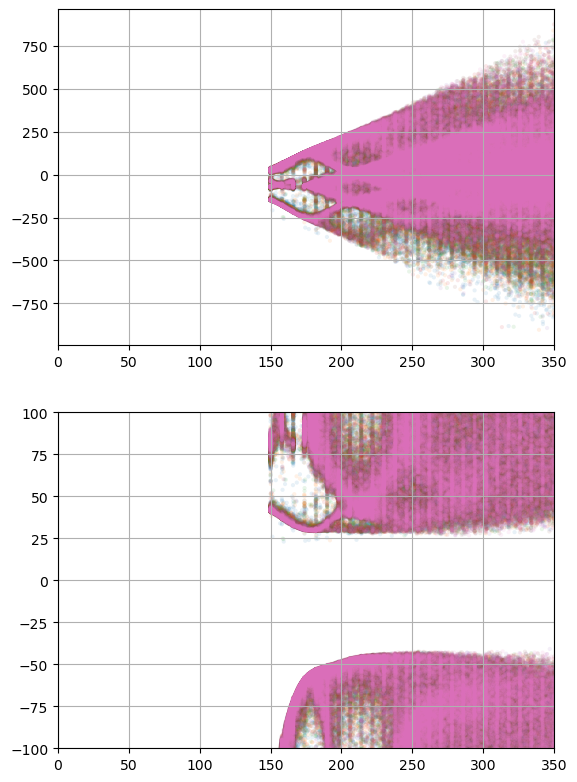

(-100.0, 100.0)

In [6]:
weights_flat = (1, 1, 1, 1, 1, 1, 1)
figure(figsize=[6.4, 4.8 * 2])
subplot(2, 1, 1)
scatter(get_all_areas(gate_data[80], weights_flat)..., marker=".", alpha=0.1, color="C0", edgecolors="none")
scatter(get_all_areas(gate_data[100], weights_flat)..., marker=".", alpha=0.1, color="C1", edgecolors="none")
scatter(get_all_areas(gate_data[120], weights_flat)..., marker=".", alpha=0.1, color="C2", edgecolors="none")
scatter(get_all_areas(gate_data[140], weights_flat)..., marker=".", alpha=0.1, color="C3", edgecolors="none")
scatter(get_all_areas(gate_data[160], weights_flat)..., marker=".", alpha=0.1, color="C4", edgecolors="none")
scatter(get_all_areas(gate_data[180], weights_flat)..., marker=".", alpha=0.1, color="C5", edgecolors="none")
scatter(get_all_areas(gate_data[200], weights_flat)..., marker=".", alpha=0.1, color="C6", edgecolors="none")
grid()
xlim([0, 350])

subplot(2, 1, 2)
scatter(get_all_rel_areaδs(gate_data[80], weights_flat)..., marker=".", alpha=0.1, color="C0", edgecolors="none")
scatter(get_all_rel_areaδs(gate_data[100], weights_flat)..., marker=".", alpha=0.1, color="C1", edgecolors="none")
scatter(get_all_rel_areaδs(gate_data[120], weights_flat)..., marker=".", alpha=0.1, color="C2", edgecolors="none")
scatter(get_all_rel_areaδs(gate_data[140], weights_flat)..., marker=".", alpha=0.1, color="C3", edgecolors="none")
scatter(get_all_rel_areaδs(gate_data[160], weights_flat)..., marker=".", alpha=0.1, color="C4", edgecolors="none")
scatter(get_all_rel_areaδs(gate_data[180], weights_flat)..., marker=".", alpha=0.1, color="C5", edgecolors="none")
scatter(get_all_rel_areaδs(gate_data[200], weights_flat)..., marker=".", alpha=0.1, color="C6", edgecolors="none")
grid()
xlim([0, 350])
ylim([-100, 100])

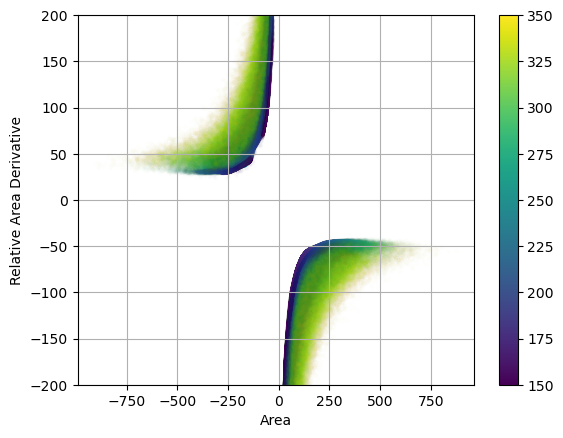

1-element Vector{Nothing}:
 nothing

In [7]:
ts, as, aδs = get_all_area_rel_areaδs(gate_data, (1, 1, 1, 1, 1, 1, 1))
scatter(as, aδs, c=ts, marker=".", alpha=0.01, edgecolors="none")
grid()
xlabel("Area")
ylabel("Relative Area Derivative")
ylim([-200, 200])
cbar = colorbar()
cbar.solids.set(alpha=1)

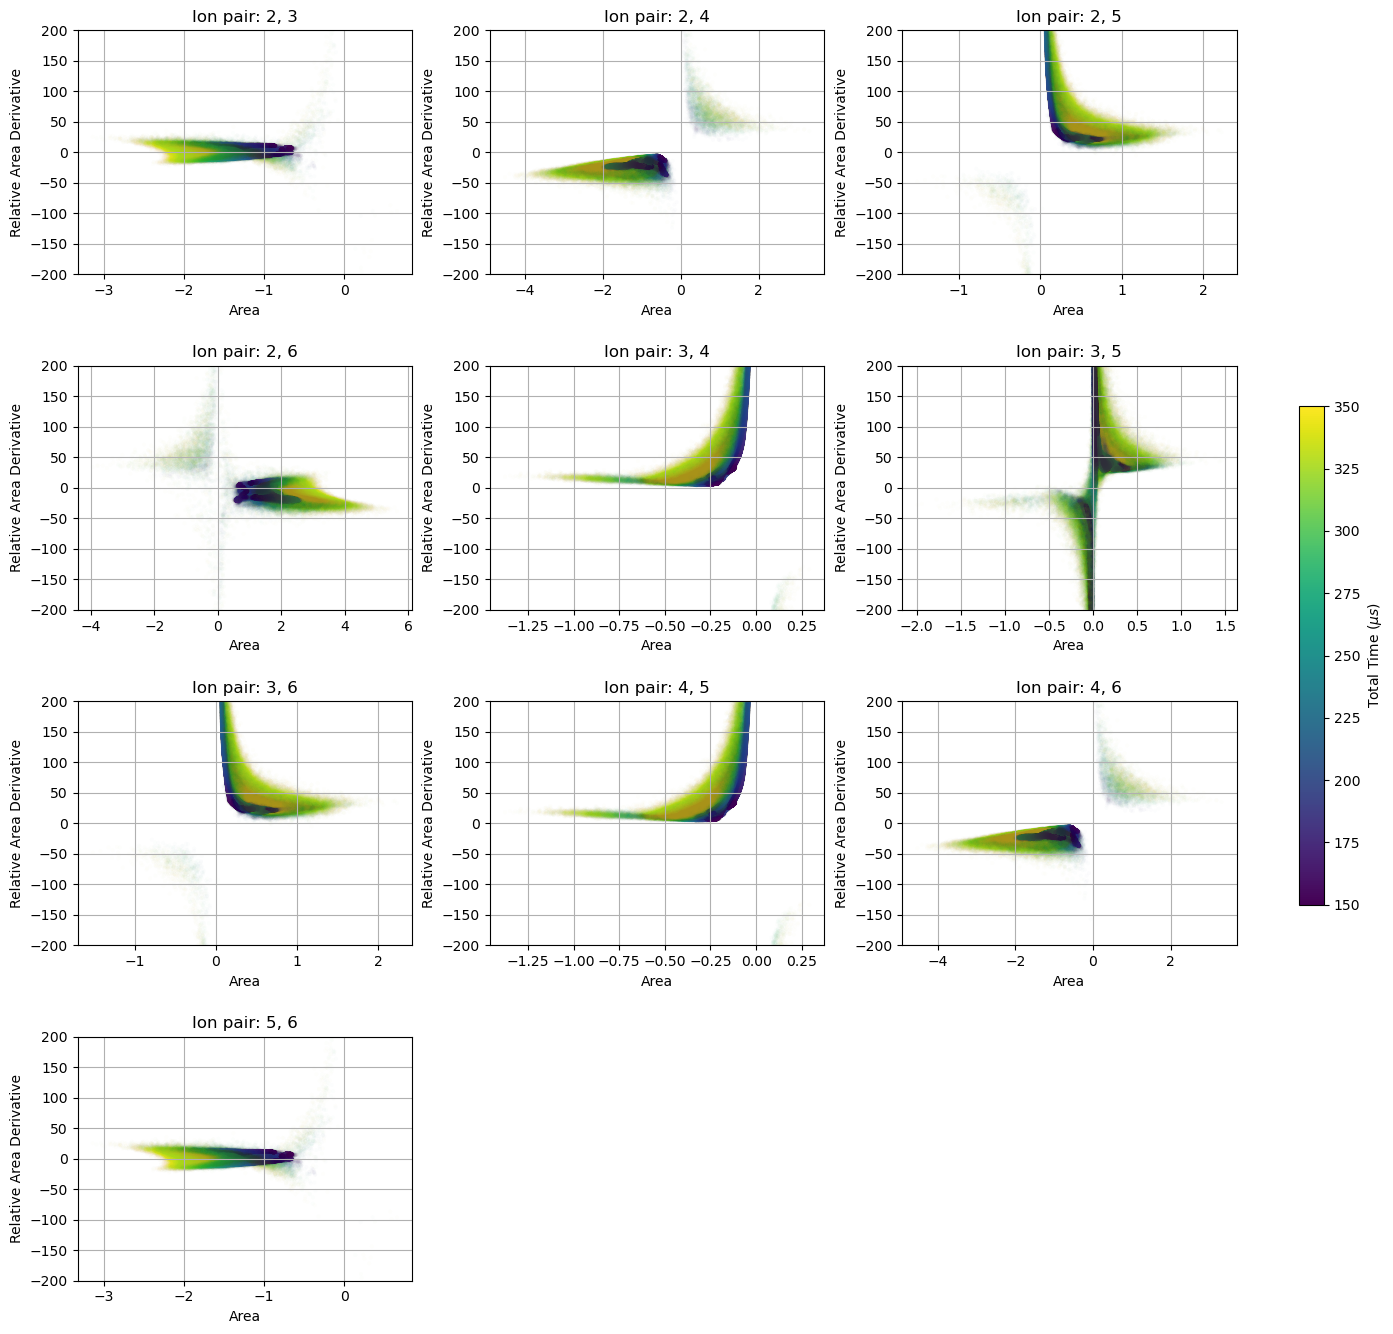

In [8]:
fig = figure(figsize=[6.4 * 3 * 0.7, 4.8 * 4 * 0.7])
axes = []
for ion1 in 2:5
    for ion2 in ion1 + 1:6
        global sp
        push!(axes, subplot(4, 3, length(axes) + 1))
        ts, as, aδs = get_all_area_rel_areaδs(gate_data, mode_weight!(zeros(7), ion1, ion2))
        sp = scatter(as, aδs, c=ts, marker=".", alpha=0.01, edgecolors="none")
        grid()
        xlabel("Area")
        ylabel("Relative Area Derivative")
        ylim([-200, 200])
        title("Ion pair: $(ion1), $(ion2)")
        # cbar = colorbar()
        # cbar.solids.set(alpha=1)
    end
end
tight_layout(h_pad=2)
cbar = fig.colorbar(sp, ax=axes, shrink=0.6, fraction=0.02, label=raw"Total Time ($\mu s$)")
cbar.solids.set(alpha=1)
savefig("imgs/opt1_area_2d.png"; bbox_inches="tight", transparent=true)